<a href="https://colab.research.google.com/github/faizanurrahman/temp_data/blob/master/EDA_on_H_Connect_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement And Understanding

Health Care Connect, or H-Connect, is a Job search plateform, which provide intelligent sevices to make recuriment process batter for everyone. This time H-Connect want to build a new feature in his plateform that can help recruiters suggest a job type and job category based on job description. 

In this, H-Connect provides a Dataset which contain job description, job type, and job category based on this we have to build a model which predict the job type and job category based on job description. Let's dive into dataset and make some useful insite.


In [0]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora, models, similarities
# function to clean and lemmatize text and remove stopwords
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_numeric
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.stem.wordnet import WordNetLemmatizer
import re
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('words')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('maxent_ne_chunker')



# setting up default plotting parameters
%matplotlib inline

#plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Data Understanding and Exploration

In [0]:
# Read in the train and test file
train = pd.read_csv('./DataSet/train.csv')
test = pd.read_csv('./DataSet/test.csv')
sample_submission = pd.read_csv('./DataSet/sample_submission.csv')
train.head(2)


,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research


In [0]:
# Size of Dataset's
print(f"Train Data Shape: {train.shape}")
print(f"\nTest Data Shape: {test.shape}")


Train Data Shape: (17657, 5)

Test Data Shape: (11771, 2)


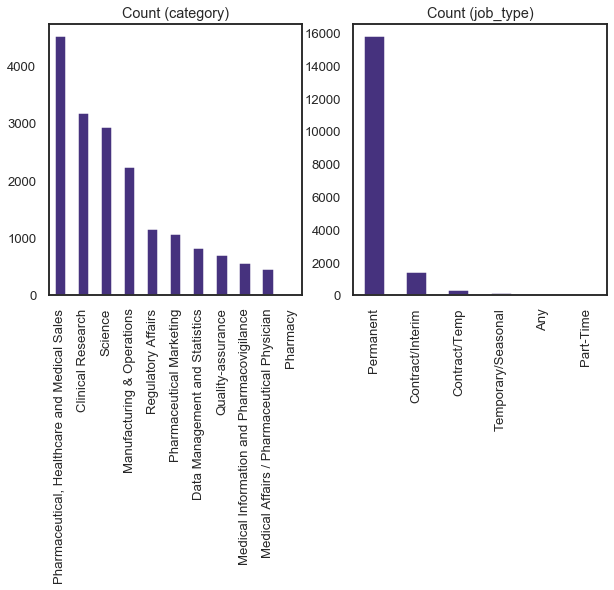

In [0]:
# Check class distribution
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
train.category.value_counts().plot(kind='bar', title='Count (category)', ax=ax1)
train.job_type.value_counts().plot(kind='bar', title='Count (job_type)', ax=ax2)

In [0]:
# Concatenate target variables in one columns
train['target'] = train[['job_type', 'category']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
counts = train['target'].value_counts()
print(counts)

Permanent, Pharmaceutical, Healthcare and Medical Sales             4187
Permanent, Clinical Research                                        2854
Permanent, Science                                                  2635
Permanent, Manufacturing & Operations                               1841
Permanent, Pharmaceutical Marketing                                 1025
Permanent, Regulatory Affairs                                       1022
Permanent, Data Management and Statistics                            693
Permanent, Quality-assurance                                         553
Permanent, Medical Information and Pharmacovigilance                 507
Permanent, Medical Affairs / Pharmaceutical Physician                434
Contract/Interim, Manufacturing & Operations                         321
Contract/Interim, Pharmaceutical, Healthcare and Medical Sales       301
Contract/Interim, Clinical Research                                  218
Contract/Interim, Science                          

In [0]:
# Create two sample of data
train_1 = train[~train['target'].isin(counts[counts<100].index)]
train_2 = train[train['target'].isin(counts[counts<100].index)]

Text classification with very high accuracy rates are possible (north of 95%) but to acheive those you need to do a lot of text preprocessing before you run your machine learning models.

The key challenge with text processing is to process the text in a suffecient manner that the algorithm of choice is able to detect enough structure within the text decipher a neat signal.

The following helps

Word removal-experiment with word removals both in high frequency and low frequency space
Taxonomy- Ordered heirarchial taxonomy can help you reduce entropy in content. Similar to what decision trees accomplish. This is SUPER unappreciated in most text analytics literature
Lemmatization. _ it sometimes helps improve structure of text
Sampling - Are your classes balanced? if not resample, create synthetic data to populate low frequency classes
ensemble/boosting/bagging methods- Have you tried meta algos to improve your performance?
Data Quality check- Good data is like good food. Have you checked if you have any useless data? pruning data set helps improve structure a lot!
Hyper Parameter tuning- Did you exhaustively search the subspaces to fine tune the model. Most models show upto 10% improvement by just hyperparameter tuning.
Word Gram conversion- you can improve feature set by converting important bigrams and trigrams into unigrams "food processing" can be changed to "food_processing"
Data preparation- Count vectors, tf-idf, word2vec .. et al.. Naive bayes seems to work better Count vectors,
Sample length- This is a quirk i noticed in text mining. if you are classifying sentences ranging from few words to lets say a paragraph. With more additional words algos like naive bayes dont work well due lack of convergence arising from positive hits they get from all words for more that one class to put it naively (pun intended :P)
Last point I can think is instead of getting class assignment get class probabilities and use that itself a feature in your ensembles. It seems to work in a variety of cases.

In [0]:
from string import punctuation
def preprocess_string(s):
    
    global punctuation
    global en_stopwords
    # some problems with the way Job Description has been encoded to utf-8
    s = str(s)
    
    # Remove Punctuations
    for p in punctuation:
        s = s.replace(p, '')

    # Remove the urls first - Anything that has .com, .co.uk or www. is a url!
    s = re.sub('[^\s]*.com[^\s]*', "", s)
    s = re.sub('[^\s]*www.[^\s]*', "", s)
    s = re.sub('[^\s]*.co.uk[^\s]*', "", s)

    # Removed Numbers
    s = re.sub('[^\s]*[0-9]+[^\s]*', "", s)

    # Remove special Charecter
    s = re.sub('[^\s]*[\*]+[^\s]*', "", s)
    s = re.sub(r'\([^)]*\)', '', s)

    # Convert to lower
    s = s.lower()
    
    # tockenize text
    s = nltk.word_tokenize(s)

    # lemmatize and remove stopword
    s = " ".join([lmtzr.lemmatize(token) for token in s if token not in en_stopwords])

    # part-of-speech tagger
    s = nltk.pos_tag(s)
    
    # document label categorizer 
    pattern = 'NP: {<DT>?<JJ>*<NN>}'
    cp = nltk.RegexpParser(pattern)
    cs = cp.parse(s)
    iob_tagged = tree2conlltags(cs)
    s = "".join([word for word, pos, ner in iob_tagged])

    return s



In [0]:
lmtzr = WordNetLemmatizer()
en_stopwords = stopwords.words('english')
add_words =['su', 'de', 'la','de', 'et', 'un', 'le', 'und', 'y','la', 'en', 'el', 'una', 'es']
en_stopwords.extend(add_words)
print("text processng start: ")
%time train['clean_job_description'] = train['job_description'].map(preprocess_string)
print("train data processed: ")
%time test['clean_job_description'] = test['job_description'].map(preprocess_string)
print("test data processed: ")

train.to_csv('./Dataset/clean_train.csv', index = False)
test.to_csv('./Dataset/clean_test.csv', index = False)
print("finished: ")

text processng start: 
Wall time: 58min 54s
train data processed: 
Wall time: 39min 47s
test data processed: 
finished: 


hi
Wall time: 0 ns
hik
Wall time: 0 ns


In [0]:
# create ngrams
ngram_phraser = models.Phrases(train.clean_job_description.values, threshold=1)
ngram = models.phrases.Phraser(ngram_phraser)
#print example
print(ngram[train.clean_job_description[0]])

# apply model to corpus
texts = [ngram[token] for token in train.clean_job_description]

# preparing ngrams for modeling
texts = [''.join(text) for text in texts]
train['ngrams'] = texts

['z', 'e', 's', 't', ' ', 's', 'c', 'i', 'e', 'n', 't', 'i', 'f', 'i', 'c', ' ', 's', 'e', 'a', 'r', 'c', 'h', 'i', 'n', 'g', ' ', 's', 'c', 'i', 'e', 'n', 't', 'i', 'f', 'i', 'c', ' ', 's', 'a', 'l', 'e', ' ', 'p', 'r', 'o', 'f', 'e', 's', 's', 'i', 'o', 'n', 'a', 'l', ' ', 'n', 'e', 't', 'h', 'e', 'r', 'l', 'a', 'n', 'd', 's', ' ', 't', 'e', 'r', 'r', 'i', 't', 'o', 'r', 'y', ' ', 'p', 'l', 'a', 'y', ' ', 'p', 'i', 'v', 'o', 't', 'a', 'l', ' ', 'r', 'o', 'l', 'e', ' ', 'i', 'n', 'c', 'r', 'e', 'a', 's', 'e', ' ', 'p', 'r', 'e', 's', 'e', 'n', 'c', 'e', ' ', 'a', 'c', 'r', 'o', 's', 's', ' ', 'e', 'u', 'r', 'o', 'p', 'e', ' ', 'p', 'r', 'e', 's', 'e', 'n', 't', 'i', 'n', 'g', ' ', 'w', 'e', 'a', 'l', 't', 'h', ' ', 'u', 'n', 't', 'a', 'p', 'p', 'e', 'd', ' ', 'p', 'o', 't', 'e', 'n', 't', 'i', 'a', 'l', ' ', 'c', 'l', 'i', 'e', 'n', 't', ' ', 'i', 'n', 't', 'e', 'r', 'n', 'a', 't', 'i', 'o', 'n', 'a', 'l', 'l', 'y', ' ', 'r', 'e', 'c', 'o', 'g', 'n', 'i', 'z', 'e', 'd', ' ', 'p', 'r',

In [0]:
train.ngrams.head()

0    zest scientific searching scientific sale prof...
1    mundo los cro típicos está haciendo grandes ol...
2    asha mistry umbilical life recruiting experien...
3    sale representative laser der medizintechnik m...
4    field service engineer life science cambridge ...
Name: ngrams, dtype: object